<a href="https://colab.research.google.com/github/NishaNattha/WasteClassification/blob/main/Waste_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
from PIL import Image
import shutil

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import joblib
from keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Image Preprocess**

In [ ]:
image_folder = "image"
processed_folder = "process_dataset"

image_folder = os.path.join(image_folder, "image")

resize_dim = (224, 224)
datagen = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.3
)

os.makedirs(processed_folder, exist_ok=True)

for class_folder in os.listdir(image_folder):
    class_folder_path = os.path.join(image_folder, class_folder)
    processed_class_folder = os.path.join(processed_folder, class_folder)
    os.makedirs(processed_class_folder, exist_ok=True)

    if os.path.isdir(class_folder_path):
        for image_name in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_name)

            try:
                with Image.open(image_path) as img:
                    img = img.convert('RGB')
                    img_resized = img.resize(resize_dim)
                    img_array = np.array(img_resized)

                    if img_array.ndim == 3:
                        img_array = img_array.reshape((1,) + img_array.shape)
                    else:
                        raise ValueError(f"Image {image_name} does not have 3 channels (RGB).")

                    resized_image_path = os.path.join(processed_class_folder, image_name)
                    img_resized.save(resized_image_path)

                    aug_count = 0
                    for batch in datagen.flow(img_array, batch_size=1,
                                              save_to_dir=processed_class_folder,
                                              save_prefix=os.path.splitext(image_name)[0],
                                              save_format="png"):
                        aug_count += 1
                        if aug_count >= 2:
                            break

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

print("Resizing and augmentation completed!")

Resizing and augmentation completed!
Dataset successfully zipped at /content/drive/MyDrive/Colab Notebooks/ProjectDL/process_dataset.zip


In [ ]:
dataset_folder = "/content/drive/MyDrive/Colab Notebooks/ProjectDL/process_dataset"

image_size = (224, 224)
num_classes = 5

X = []
y = []
class_names = ['plastic', 'paper', 'glass', 'metal', 'waste']

for label, class_name in enumerate(class_names):
    class_folder_path = os.path.join(dataset_folder, class_name)
    for image_name in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_name)
        try:
            img = load_img(image_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(label)
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

In [ ]:
X = np.array(X)
y = np.array(y)

# **SVM**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
#SVM_linear
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_flat, y_train)

In [ ]:
svm_test_preds = svm_model.predict(X_test_flat)

In [ ]:
print("SVM Test Report:")
print(classification_report(y_test, svm_test_preds))

SVM Test Report:
              precision    recall  f1-score   support

           0       0.44      0.51      0.47        90
           1       0.45      0.48      0.46        90
           2       0.40      0.34      0.37        90
           3       0.40      0.43      0.41        90
           4       0.71      0.60      0.65        90

    accuracy                           0.47       450
   macro avg       0.48      0.47      0.48       450
weighted avg       0.48      0.47      0.48       450



Text(0.5, 1.0, 'SVM Confusion_matrix')

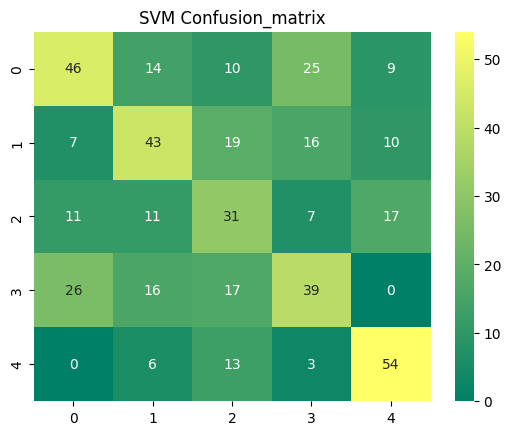

In [ ]:
sns.heatmap(confusion_matrix(svm_test_preds,y_test),annot=True,cmap='summer')
plt.title('SVM Confusion_matrix')

In [ ]:
#SVM_rbf
svm_model = SVC(kernel='rbf', probability=True)
hist = svm_model.fit(X_train_flat, y_train)

In [ ]:
svm_test_preds = svm_model.predict(X_test_flat)

In [ ]:
print("SVM Test Report 'rbf':")
print(classification_report(y_test, svm_test_preds))

SVM Test Report 'rbf':
              precision    recall  f1-score   support

           0       0.57      0.77      0.66        90
           1       0.60      0.57      0.58        90
           2       0.53      0.60      0.57        90
           3       0.59      0.22      0.32        90
           4       0.65      0.79      0.71        90

    accuracy                           0.59       450
   macro avg       0.59      0.59      0.57       450
weighted avg       0.59      0.59      0.57       450



Text(0.5, 1.0, "SVM Confusion_matrix 'rbf'")

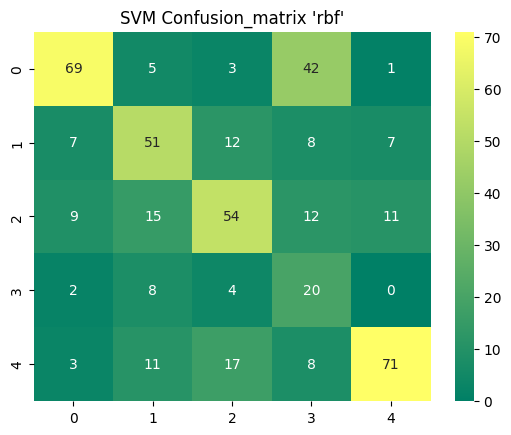

In [ ]:
sns.heatmap(confusion_matrix(svm_test_preds,y_test),annot=True,cmap='summer')
plt.title("SVM Confusion_matrix 'rbf'")

# **ANNs**

In [ ]:
#ANN
X_flat = X.reshape(X.shape[0], -1)

sc = StandardScaler()
X_flat_sc = sc.fit_transform(X_flat)

In [ ]:
y_cat = to_categorical(y, num_classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_flat_sc, y_cat, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

In [ ]:
#ANN_1
ann_model = Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    #keras.layers.Dense(128, activation = 'relu'),
    #keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(5, activation = 'softmax')
])

ann_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       9,633,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,636,101 (36.76 MB)

 Trainable params: 9,636,101 (36.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#with tf.device('/device:GPU:0'):
hist = ann_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=100)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step - accuracy: 0.2890 - loss: 42.2689 - val_accuracy: 0.4028 - val_loss: 29.1434
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.4848 - loss: 20.9892 - val_accuracy: 0.4500 - val_loss: 17.5117
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.5479 - loss: 11.5919 - val_accuracy: 0.4500 - val_loss: 14.6420
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.6351 - loss: 7.9010 - val_accuracy: 0.4056 - val_loss: 17.5677
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.6878 - loss: 6.0432 - val_accuracy: 0.4306 - val_loss: 19.7097
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.6652 - loss: 11.6412 - val_accuracy: 0.4778 - val_loss: 21.0500
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.6398 - loss: 9.3629 - val_accuracy: 0.4750 - val_loss: 17.0878
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - accuracy: 0.7061 - loss: 6.2602 - val_a

In [ ]:
y_pred = ann_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


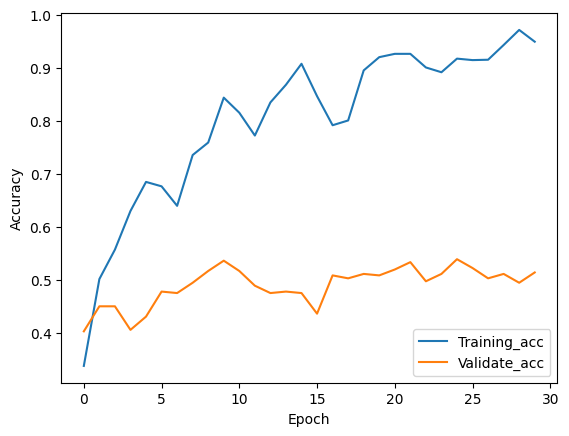

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training_acc', 'Validate_acc'], loc = 'lower right')

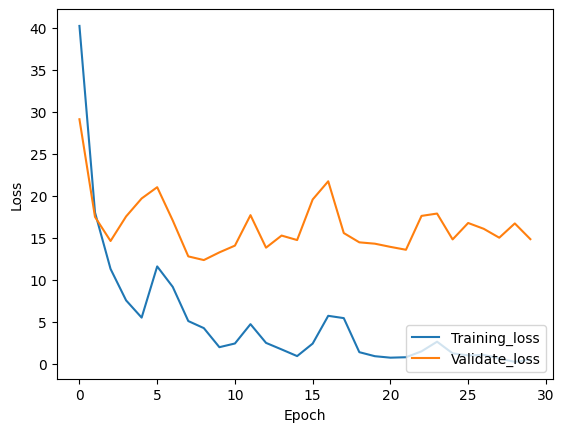

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training_loss', 'Validate_loss'], loc = 'lower right')

In [ ]:
y_test_label = np.argmax(y_test, axis=-1)

In [ ]:
print("ANN Test Report:")
print(classification_report(y_test_label, y_pred))

ANN Test Report:
              precision    recall  f1-score   support

           0       0.41      0.51      0.46        90
           1       0.43      0.32      0.37        90
           2       0.58      0.68      0.63        90
           3       0.54      0.36      0.43        90
           4       0.60      0.72      0.66        90

    accuracy                           0.52       450
   macro avg       0.51      0.52      0.51       450
weighted avg       0.51      0.52      0.51       450



Text(0.5, 1.0, 'ANNs Confusion_matrix')

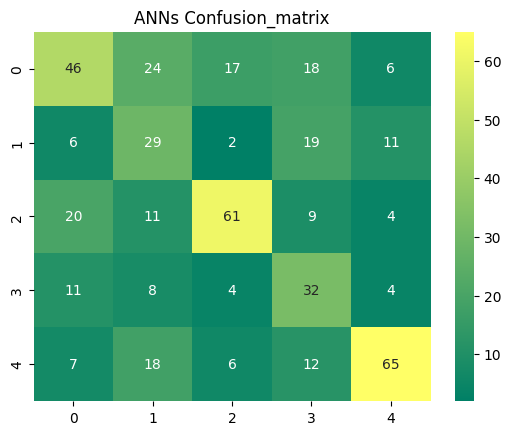

In [ ]:
sns.heatmap(confusion_matrix(y_pred,y_test_label),annot=True,cmap='summer')
plt.title("ANNs Confusion_matrix")

# **CNN**

In [ ]:
#CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.2594 - loss: 4.8831 - val_accuracy: 0.3917 - val_loss: 1.3303
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.4351 - loss: 1.3448 - val_accuracy: 0.5111 - val_loss: 1.1367
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5288 - loss: 1.1203 - val_accuracy: 0.5889 - val_loss: 1.1173
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6014 - loss: 1.0045 - val_accuracy: 0.5472 - val_loss: 1.1408
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.6988 - loss: 0.8499 - val_accuracy: 0.6028 - val_loss: 1.0467
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.7596 - loss: 0.6447 - val_accuracy: 0.6500 - val_loss: 0.9658
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.8278 - loss: 0.5056 - val_accuracy: 0.6389 - val_loss: 1.0166
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8451 - loss: 0.4374 - val_accuracy: 0.6639 - v

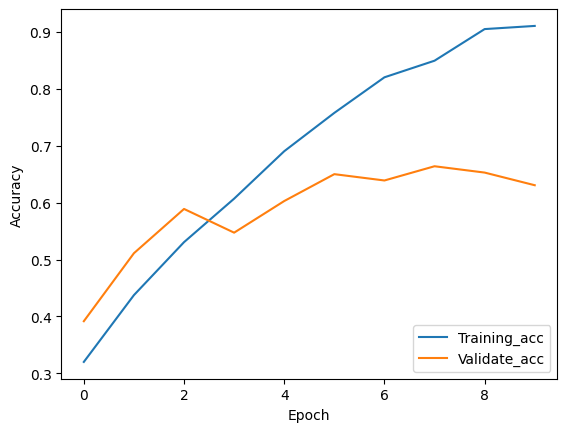

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training_acc', 'Validate_acc'], loc = 'lower right')

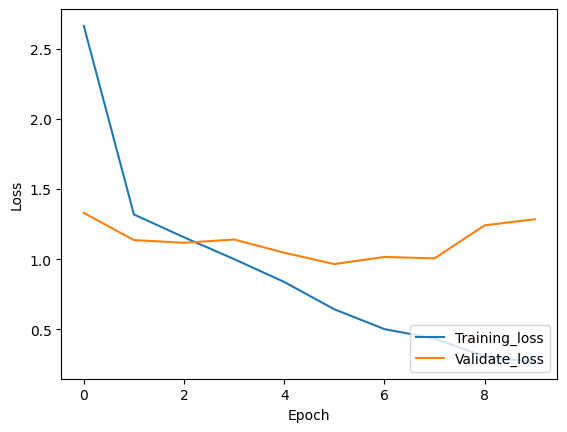

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training_loss', 'Validate_loss'], loc = 'lower right')

In [ ]:
y_pred = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 731ms/step


In [ ]:
y_test = np.argmax(y_test, axis=-1)

In [ ]:
print("CNN Test Report:")
print(classification_report(y_test, y_pred))

CNN Test Report:
              precision    recall  f1-score   support

           0       0.81      0.49      0.61        90
           1       0.48      0.50      0.49        90
           2       0.62      0.53      0.57        90
           3       0.51      0.61      0.56        90
           4       0.68      0.88      0.76        90

    accuracy                           0.60       450
   macro avg       0.62      0.60      0.60       450
weighted avg       0.62      0.60      0.60       450



Text(0.5, 1.0, 'CNN Confusion_matrix')

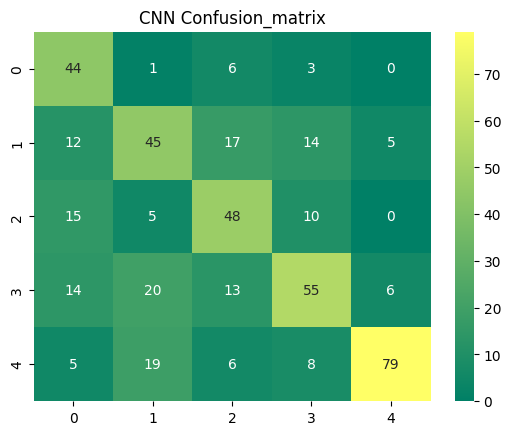

In [ ]:
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,cmap='summer')
plt.title("CNN Confusion_matrix")